Using device: cuda

Loading dataset for GAN training...
- X_raw shape: (101916, 128, 19)
- y_labels shape: (101916, 3)
Normalizing data...
Freeing original raw data from memory...
Prepared DataLoader and freed intermediate arrays.

Starting GAN training...
Epoch [20/60], D Loss: 1.2804, G Loss: 1.1904
Epoch [40/60], D Loss: 1.3639, G Loss: 0.6131
Epoch [60/60], D Loss: 1.3798, G Loss: 0.6999


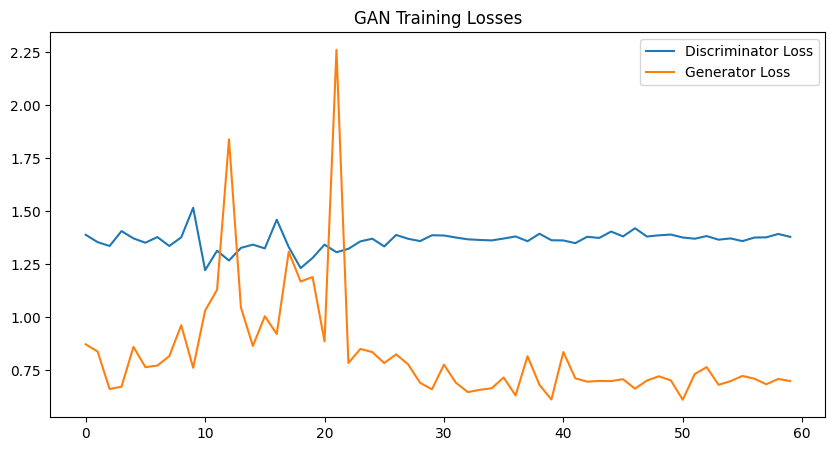

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import gc # Garbage Collector interface

# ===================================================================
# SETUP
# ===================================================================
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===================================================================
# DATA LOADING & PREPARATION
# ===================================================================
print("\nLoading dataset for GAN training...")
try:
    # Load only the data needed for this step
    with np.load("/kaggle/input/largest-alzheimer-eeg-dataset/integrated_eeg_dataset.npz") as data:
        X_raw = data['X_raw']
        y_labels = data['y_labels']
    
    y = y_labels[:, 0].astype(float).astype(int)
    print(f"- X_raw shape: {X_raw.shape}")
    print(f"- y_labels shape: {y_labels.shape}")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# --- Memory-Efficient Normalization ---
print("Normalizing data...")
# Normalize each channel separately. This is done in-place on a copy.
X_normalized = np.empty_like(X_raw, dtype=np.float32)
for c in range(X_raw.shape[2]):
    min_val = X_raw[:, :, c].min()
    max_val = X_raw[:, :, c].max()
    X_normalized[:, :, c] = 2 * ((X_raw[:, :, c] - min_val) / (max_val - min_val)) - 1

# --- Explicitly free memory ---
print("Freeing original raw data from memory...")
del X_raw
gc.collect()

# Convert to PyTorch tensors
X_tensor = torch.from_numpy(X_normalized)
y_tensor = torch.from_numpy(y) # Not used for GAN, but good practice

# Create dataset and dataloader
batch_size = 128
dataset = TensorDataset(X_tensor) # We don't need labels for unconditional GAN
# --- OPTIMIZED DATALOADER ---
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,      # Use multiple CPU cores to load data in parallel
    pin_memory=True,    # Speeds up CPU to GPU data transfer
    persistent_workers=True # Keeps workers alive, avoids re-creation overhead
)

# Free more memory
del X_normalized, X_tensor, y_tensor
gc.collect()
print("Prepared DataLoader and freed intermediate arrays.")

# ===================================================================
# GAN MODEL DEFINITION (No changes needed here)
# ===================================================================
class Generator(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super(Generator, self).__init__()
        self.output_shape = output_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.LeakyReLU(0.2), nn.BatchNorm1d(128),
            nn.Linear(128, 256), nn.LeakyReLU(0.2), nn.BatchNorm1d(256),
            nn.Linear(256, 512), nn.LeakyReLU(0.2), nn.BatchNorm1d(512),
            nn.Linear(512, np.prod(output_shape)), nn.Tanh()
        )
    def forward(self, z):
        return self.model(z).view(-1, *self.output_shape)

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(input_shape), 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# ===================================================================
# GAN TRAINING (No changes needed in the loop logic)
# ===================================================================
timesteps, channels = 128, 19 # Hardcode from dataset info
latent_dim = 100
num_epochs = 60 # Consider reducing for faster runs if needed

generator = Generator(latent_dim, (timesteps, channels)).to(device)
discriminator = Discriminator((timesteps, channels)).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

print("\nStarting GAN training...")
g_losses, d_losses = [], []
for epoch in range(num_epochs):
    for i, (real_samples,) in enumerate(dataloader):
        batch_size_real = real_samples.size(0)
        real_samples = real_samples.to(device)
        real_labels = torch.ones(batch_size_real, 1).to(device)
        fake_labels = torch.zeros(batch_size_real, 1).to(device)
        
        # Train Discriminator
        d_optimizer.zero_grad()
        d_loss = criterion(discriminator(real_samples), real_labels) + \
                 criterion(discriminator(generator(torch.randn(batch_size_real, latent_dim).to(device)).detach()), fake_labels)
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(generator(torch.randn(batch_size_real, latent_dim).to(device))), real_labels)
        g_loss.backward()
        g_optimizer.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.savefig("gan_training_losses.png")
plt.show()



In [2]:
# ===================================================================
# GENERATE & SAVE SYNTHETIC SAMPLES (Memory-Efficient)
# ===================================================================
def generate_samples(generator, num_samples, latent_dim, device):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        return generator(z).cpu().numpy()


y_numeric = np.copy(y_labels[:, 0])
y_numeric[y_numeric == '0.0'] = '0'
y_numeric[y_numeric == '1.0'] = '1'
y_numeric = y_numeric.astype(int)

# Determine samples to generate to balance the dataset
min_value = min(y_numeric)  # Find lowest label value
y_shifted = y_numeric - min_value  # Shift all values to be non-negative
class_counts = np.bincount(y_shifted)  # Works now!

max_count = np.max(class_counts)
samples_to_generate = max_count - class_counts

print("\nOriginal class distribution:")
for i, count in enumerate(class_counts):
    original_label = i + min_value
    print(f"Class {original_label}: {count} samples")

synthetic_samples_list = []
synthetic_labels_list = []

for class_idx_shifted, num_to_gen in enumerate(samples_to_generate):
    if num_to_gen > 0:
        original_label_val = class_idx_shifted + min_value
        
        # We only want to generate for classes 0 and 1, not -1 or 2
        if original_label_val in [0, 1]:
            print(f"Generating {num_to_gen} synthetic samples for class {original_label_val}...")
            generated_data = generate_samples(generator, num_to_gen, latent_dim, device)
            synthetic_samples_list.append(generated_data)

            # Create corresponding labels
            generated_labels = np.zeros((num_to_gen, y_labels.shape[1]), dtype=object)
            
            # --- THIS IS THE FIX ---
            # Save the label as a STRING to match the cleaning logic later
            generated_labels[:, 0] = str(original_label_val) 
            # --- END OF FIX ---
            
            generated_labels[:, 1] = -1         # Subject ID (-1 for synthetic)
            generated_labels[:, 2] = "synthetic"  # Dataset name
            synthetic_labels_list.append(generated_labels)

# --- Combine ONLY the newly generated samples ---
if synthetic_samples_list:
    X_synthetic = np.concatenate(synthetic_samples_list, axis=0)
    y_synthetic = np.concatenate(synthetic_labels_list, axis=0)
    print(f"\nGenerated a total of {X_synthetic.shape[0]} synthetic samples.")
else:
    # Handle the case where the dataset is already balanced
    X_synthetic = np.array([])
    y_synthetic = np.array([])
    print("\nDataset is already balanced. No new samples generated.")

# --- Save original and synthetic data separately to avoid large concatenation ---
try:
    print("Reloading original data to save alongside synthetic data...")
    with np.load("/kaggle/input/largest-alzheimer-eeg-dataset/integrated_eeg_dataset.npz") as data:
        X_original = data['X_raw']
        y_original = data['y_labels']

    save_path = "/kaggle/working/augmented_eeg_dataset.npz"
    np.savez_compressed(
        save_path,
        X_original=X_original,
        y_original=y_original,
        X_synthetic=X_synthetic,
        y_synthetic=y_synthetic
    )
    print(f"\nAugmented dataset components saved successfully to {save_path}")
    print(f"File contains: X_original, y_original, X_synthetic, y_synthetic")

except Exception as e:
    print(f"Error saving augmented dataset: {e}")


Original class distribution:
Class -1: 1179 samples
Class 0: 33701 samples
Class 1: 28603 samples
Class 2: 38433 samples
Generating 4732 synthetic samples for class 0...
Generating 9830 synthetic samples for class 1...

Generated a total of 14562 synthetic samples.
Reloading original data to save alongside synthetic data...

Augmented dataset components saved successfully to /kaggle/working/augmented_eeg_dataset.npz
File contains: X_original, y_original, X_synthetic, y_synthetic


Using device: cuda

STEP 1: PROCESSING AND TRAINING ON ORIGINAL DATASET

Loading and CLEANING original dataset...
Original total sample count: 101916
Found 62304 valid samples for binary classification (Classes 0 & 1).
Discarding 39612 samples with labels like '-1' and '2'.
Final clean dataset size: 62304 samples.
Clean class distribution: Class 0: 33701, Class 1: 28603
Extracting features for 62304 samples in batches of 1024...
  Processed 1024/62304 samples...
  Processed 11264/62304 samples...
  Processed 21504/62304 samples...
  Processed 31744/62304 samples...
  Processed 41984/62304 samples...
  Processed 52224/62304 samples...
  Processed 62304/62304 samples...
Feature extraction complete.

Training model on original data...
Epoch 5/30, Val Acc: 0.8115
Epoch 10/30, Val Acc: 0.8089
Epoch 15/30, Val Acc: 0.8466
Epoch 20/30, Val Acc: 0.8556
Epoch 25/30, Val Acc: 0.8553
Epoch 30/30, Val Acc: 0.8609
Training finished. Best validation accuracy: 0.8609

STEP 2: PROCESSING AND TRAINING 

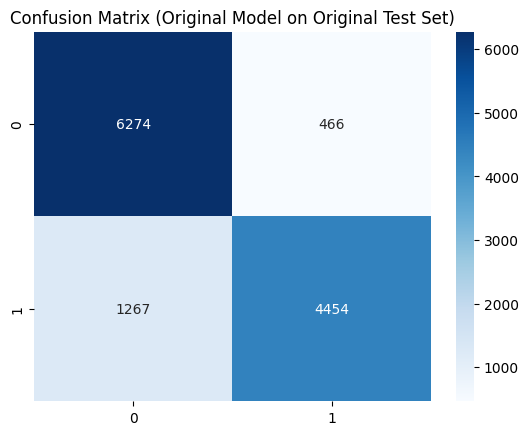


--- Full Evaluation on Augmented Model on Augmented Test Set ---
              precision    recall  f1-score   support

     Class 0       0.87      0.79      0.83      7687
     Class 1       0.80      0.88      0.84      7687

    accuracy                           0.83     15374
   macro avg       0.84      0.83      0.83     15374
weighted avg       0.84      0.83      0.83     15374



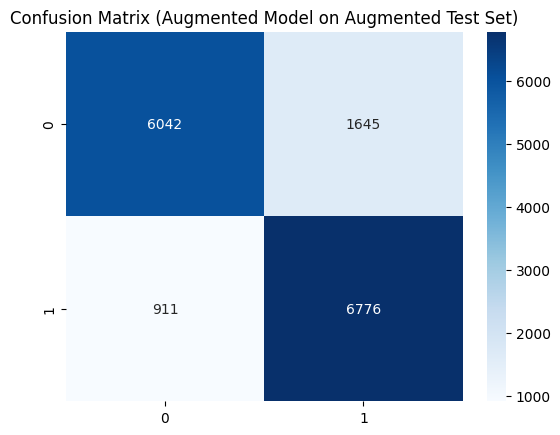


--- Cross-Evaluation ---

--- Full Evaluation on Original Model on Augmented Test Set ---
              precision    recall  f1-score   support

     Class 0       0.84      0.82      0.83      7687
     Class 1       0.83      0.84      0.83      7687

    accuracy                           0.83     15374
   macro avg       0.83      0.83      0.83     15374
weighted avg       0.83      0.83      0.83     15374



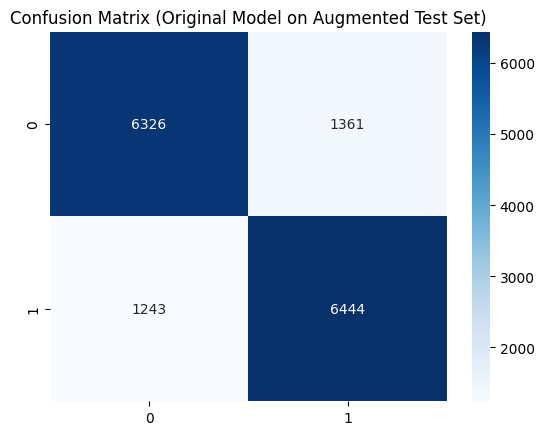


--- Full Evaluation on Augmented Model on Original Test Set ---
              precision    recall  f1-score   support

     Class 0       0.87      0.90      0.89      6740
     Class 1       0.88      0.85      0.86      5721

    accuracy                           0.87     12461
   macro avg       0.87      0.87      0.87     12461
weighted avg       0.87      0.87      0.87     12461



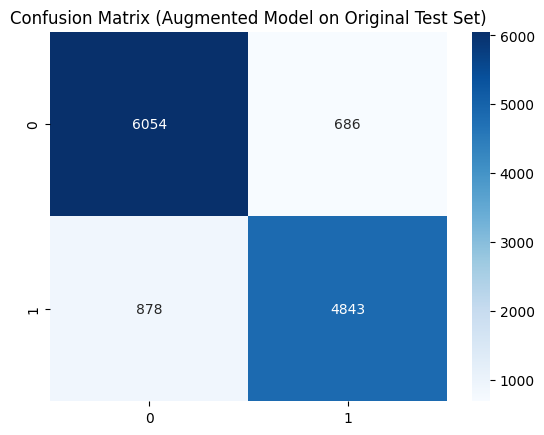

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from scipy.integrate import simpson as simps
import gc

# ===================================================================
# SETUP
# ===================================================================
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ===================================================================
# BATCHED FEATURE EXTRACTION (MEMORY EFFICIENT)
# ===================================================================
def extract_enhanced_features(X_batch, sfreq=128):
    """
    Extracts features for a single batch of data.
    X_batch shape: [batch_size, n_timesteps, n_channels]
    """
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 50)}
    nperseg = X_batch.shape[1]
    
    freqs, psd = welch(X_batch, fs=sfreq, nperseg=nperseg, axis=1)
    psd = np.transpose(psd, (0, 2, 1)) # Transpose to (batch, channels, freqs)
    
    all_band_powers = []
    freq_res = freqs[1] - freqs[0]
    for band_limits in bands.values():
        band_idx = np.logical_and(freqs >= band_limits[0], freqs <= band_limits[1])
        bp = simps(psd[:, :, band_idx], dx=freq_res, axis=-1)
        all_band_powers.append(bp)
        
    abs_bp = np.stack(all_band_powers, axis=-1)
    total_power = abs_bp.sum(axis=-1, keepdims=True)
    total_power[total_power == 0] = 1e-10
    rel_bp = abs_bp / total_power
    
    features = np.concatenate([
        rel_bp.reshape(X_batch.shape[0], -1),
        abs_bp.reshape(X_batch.shape[0], -1),
        X_batch.mean(axis=1),
        X_batch.std(axis=1),
        X_batch.max(axis=1),
        X_batch.min(axis=1)
    ], axis=1)
    return features

def extract_features_in_batches(X_raw, batch_size=1024):
    """
    Processes a large raw data array in smaller batches to conserve memory.
    """
    n_samples = X_raw.shape[0]
    all_features = []
    print(f"Extracting features for {n_samples} samples in batches of {batch_size}...")
    for i in range(0, n_samples, batch_size):
        batch_end = min(i + batch_size, n_samples)
        X_batch = X_raw[i:batch_end]
        
        features_batch = extract_enhanced_features(X_batch)
        all_features.append(features_batch)
        
        if (i // batch_size) % 10 == 0:
            print(f"  Processed {batch_end}/{n_samples} samples...")
    
    print("Feature extraction complete.")
    return np.concatenate(all_features, axis=0)

# ===================================================================
# MODEL, TRAINING, AND EVALUATION FUNCTIONS (No changes needed)
# ===================================================================
class EnhancedEEGCNN(nn.Module):
    def __init__(self, input_features, num_classes=2):
        super(EnhancedEEGCNN, self).__init__()
        # Adjusting the architecture for 1D feature vectors
        self.features = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1), nn.BatchNorm1d(32), nn.ELU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1), nn.BatchNorm1d(64), nn.ELU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1), nn.BatchNorm1d(128), nn.ELU(), nn.MaxPool1d(2),
        )
        # Determine the flattened size dynamically
        dummy_input = torch.randn(1, 1, input_features)
        flat_size = self.features(dummy_input).view(1, -1).shape[1]
        
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(flat_size, 128), nn.Dropout(0.5), nn.ELU(), nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x.unsqueeze(1)))

def train_model(model, train_loader, test_loader, num_epochs=30, model_save_path='best_model.pth'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_acc = evaluate_accuracy(model, test_loader)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_save_path)
        if (epoch+1) % 5 == 0:
          print(f"Epoch {epoch+1}/{num_epochs}, Val Acc: {val_acc:.4f}")
    
    print(f"Training finished. Best validation accuracy: {best_acc:.4f}")
    model.load_state_dict(torch.load(model_save_path)) # Load best model
    return model

def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return correct / total

def full_evaluation(model, loader, dataset_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.to(device))
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    print(f"\n--- Full Evaluation on {dataset_name} ---")
    print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues').set_title(f'Confusion Matrix ({dataset_name})')
    plt.show()

# ===================================================================
# MAIN EXECUTION PIPELINE
# ===================================================================
if __name__ == "__main__":
    original_dataset_path = "/kaggle/input/largest-alzheimer-eeg-dataset/integrated_eeg_dataset.npz"
    augmented_dataset_path = "/kaggle/working/augmented_eeg_dataset.npz"

    # --- Step 1: Train on Original Data ---
    print("\n" + "="*50)
    print("STEP 1: PROCESSING AND TRAINING ON ORIGINAL DATASET")
    print("="*50)

    print("\nLoading and CLEANING original dataset...")
    with np.load(original_dataset_path) as data:
        X_orig_raw = data['X_raw']
        # Load labels as strings to handle '0.0' etc.
        y_labels_str = data['y_labels'][:, 0]
    
    # --- NEW ROBUST FIX: CLEANING AND FILTERING ---
    
    # 1. Define which string labels belong to our two target classes
    class_0_labels = ['0', '0.0']
    class_1_labels = ['1', '1.0']
    
    # 2. Create a boolean mask to select ONLY the samples from our target classes
    mask_class_0 = np.isin(y_labels_str, class_0_labels)
    mask_class_1 = np.isin(y_labels_str, class_1_labels)
    valid_mask = mask_class_0 | mask_class_1
    
    print(f"Original total sample count: {len(y_labels_str)}")
    print(f"Found {np.sum(valid_mask)} valid samples for binary classification (Classes 0 & 1).")
    print(f"Discarding {len(y_labels_str) - np.sum(valid_mask)} samples with labels like '-1' and '2'.")
    
    # 3. Filter both the X and y data to keep only valid samples
    X_orig_clean = X_orig_raw[valid_mask]
    y_labels_filtered = y_labels_str[valid_mask]
    
    # 4. Create the final clean integer label array (guaranteed to be 0s and 1s)
    # Start with all zeros
    y_orig_labels = np.zeros(len(y_labels_filtered), dtype=int)
    # Find where the original labels were for class 1, and set those indices to 1
    y_orig_labels[np.isin(y_labels_filtered, class_1_labels)] = 1
    
    print(f"Final clean dataset size: {X_orig_clean.shape[0]} samples.")
    print(f"Clean class distribution: Class 0: {np.sum(y_orig_labels == 0)}, Class 1: {np.sum(y_orig_labels == 1)}")
    
    # --- END OF FIX ---
    
    # Now, proceed with the perfectly clean data
    X_orig_features = extract_features_in_batches(X_orig_clean)
    del X_orig_clean, X_orig_raw, y_labels_str, y_labels_filtered; gc.collect()  # Free memory



    X_orig_tensor = torch.FloatTensor(X_orig_features)
    y_orig_tensor = torch.LongTensor(y_orig_labels)
    del X_orig_features, y_orig_labels; gc.collect()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_orig_tensor, y_orig_tensor, test_size=0.2, random_state=42, stratify=y_orig_tensor)

    orig_train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    orig_test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
    del X_train, X_test, y_train, y_test, X_orig_tensor, y_orig_tensor; gc.collect()

    input_size = orig_train_loader.dataset.tensors[0].shape[1]
    model_orig = EnhancedEEGCNN(input_features=input_size)
    print("\nTraining model on original data...")
    model_orig = train_model(model_orig, orig_train_loader, orig_test_loader, num_epochs=30, model_save_path='model_orig.pth')


    # --- Step 2: Train on Augmented Data ---
    print("\n" + "="*50)
    print("STEP 2: PROCESSING AND TRAINING ON AUGMENTED DATASET")
    print("="*50)

# In STEP 2: PROCESSING AND TRAINING ON AUGMENTED DATASET
print("\nLoading and CLEANING augmented dataset...")
with np.load(augmented_dataset_path, allow_pickle=True) as data:
    # Load all components
    X_original_raw = data['X_original']
    y_original_labels_str = data['y_original'][:, 0]
    X_synthetic_raw = data['X_synthetic']
    y_synthetic_labels_str = data['y_synthetic'][:, 0]

    # Combine original and synthetic data
    X_aug_raw = np.concatenate((X_original_raw, X_synthetic_raw), axis=0)
    y_aug_labels_str = np.concatenate((y_original_labels_str, y_synthetic_labels_str), axis=0)
    
    del X_original_raw, y_original_labels_str, X_synthetic_raw, y_synthetic_labels_str
    gc.collect()

    # --- NEW ROBUST FIX FOR AUGMENTED DATA ---
    
    # 1. Define which string labels belong to our two target classes
    class_0_labels = ['0', '0.0']
    class_1_labels = ['1', '1.0']
    
    # 2. Create a boolean mask to select ONLY the samples from our target classes
    mask_class_0 = np.isin(y_aug_labels_str, class_0_labels)
    mask_class_1 = np.isin(y_aug_labels_str, class_1_labels)
    valid_mask = mask_class_0 | mask_class_1
    
    print(f"Augmented total sample count: {len(y_aug_labels_str)}")
    print(f"Found {np.sum(valid_mask)} valid samples for binary classification (Classes 0 & 1).")
    print(f"Discarding {len(y_aug_labels_str) - np.sum(valid_mask)} samples with labels like '-1' and '2'.")
    
    # 3. Filter both the X and y data to keep only valid samples
    X_aug_clean = X_aug_raw[valid_mask]
    y_labels_filtered = y_aug_labels_str[valid_mask]
    
    # 4. Create the final clean integer label array (guaranteed to be 0s and 1s)
    y_aug_labels = np.zeros(len(y_labels_filtered), dtype=int)
    y_aug_labels[np.isin(y_labels_filtered, class_1_labels)] = 1
    
    print(f"Final clean augmented dataset size: {X_aug_clean.shape[0]} samples.")
    print(f"Clean augmented class distribution: Class 0: {np.sum(y_aug_labels == 0)}, Class 1: {np.sum(y_aug_labels == 1)}")
    
    # --- END OF FIX ---
    
    # Now, proceed with the perfectly clean augmented data
    print("\nExtracting features from the clean augmented dataset...")
    X_aug_features = extract_features_in_batches(X_aug_clean)
    print("Freeing memory...")
    del X_aug_clean, X_aug_raw, y_aug_labels_str, y_labels_filtered; gc.collect()


    X_aug_tensor = torch.FloatTensor(X_aug_features)
    y_aug_tensor = torch.LongTensor(y_aug_labels)
    del X_aug_features, y_aug_labels; gc.collect()

    X_train, X_test, y_train, y_test = train_test_split(
        X_aug_tensor, y_aug_tensor, test_size=0.2, random_state=42, stratify=y_aug_tensor)
    
    aug_train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    aug_test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
    del X_train, X_test, y_train, y_test, X_aug_tensor, y_aug_tensor; gc.collect()

    model_aug = EnhancedEEGCNN(input_features=input_size)
    print("\nTraining model on augmented data...")
    model_aug = train_model(model_aug, aug_train_loader, aug_test_loader, num_epochs=30, model_save_path='model_aug.pth')

    # --- Step 3: Final Evaluation ---
    print("\n" + "="*50)
    print("STEP 3: FINAL COMPARATIVE EVALUATION")
    print("="*50)
    
    full_evaluation(model_orig, orig_test_loader, "Original Model on Original Test Set")
    full_evaluation(model_aug, aug_test_loader, "Augmented Model on Augmented Test Set")
    
    # Cross-evaluation
    print("\n--- Cross-Evaluation ---")
    full_evaluation(model_orig, aug_test_loader, "Original Model on Augmented Test Set")
    full_evaluation(model_aug, orig_test_loader, "Augmented Model on Original Test Set")

In [4]:
import numpy as np
import os
import humanize
from datetime import datetime

def analyze_npz_file(file_path):
    """Comprehensive analysis of an NPZ file"""
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found")
        return
    
    # Get file metadata
    file_size = os.path.getsize(file_path)
    mod_time = os.path.getmtime(file_path)
    
    print(f"=== File Analysis: {os.path.basename(file_path)} ===")
    print(f"Path: {os.path.abspath(file_path)}")
    print(f"Size: {humanize.naturalsize(file_size)}")
    print(f"Modified: {datetime.fromtimestamp(mod_time).strftime('%Y-%m-%d %H:%M:%S')}")
    print("\nContents:")
    
    try:
        # Load the npz file
        with np.load(file_path, allow_pickle=True) as data:
            # Print array information
            for array_name in data.files:
                array = data[array_name]
                print(f"\nArray: {array_name}")
                print(f"  Shape: {array.shape}")
                print(f"  Data type: {array.dtype}")
                print(f"  Memory size: {humanize.naturalsize(array.nbytes)}")
                
                # Additional info for label arrays
                if array_name == 'y_labels':
                    unique_labels = np.unique(array[:, 0])
                    print(f"  Unique labels: {unique_labels}")
                    print(f"  Label distribution:")
                    for label in unique_labels:
                        count = np.sum(array[:, 0] == label)
                        print(f"    Label {label}: {count} samples ({count/len(array)*100:.1f}%)")
                
                # Sample data preview
                if len(array.shape) == 1:
                    print(f"  Sample values: {array[:5]}")
                elif len(array.shape) == 2:
                    print(f"  Sample row: {array[0, :5]}...")
                elif len(array.shape) == 3:
                    print(f"  Sample data: {array[0, 0, :5]}...")
                
                # Memory optimization suggestions
                if array.dtype == 'float64':
                    print("  Note: Consider float32 for memory savings")
    
    except Exception as e:
        print(f"Error analyzing file: {e}")

# Analyze your specific file
if __name__ == "__main__":
    file_path = "/kaggle/input/largest-alzheimer-eeg-dataset/integrated_eeg_dataset.npz"
    analyze_npz_file(file_path)

=== File Analysis: integrated_eeg_dataset.npz ===
Path: /kaggle/input/largest-alzheimer-eeg-dataset/integrated_eeg_dataset.npz
Size: 2.1 GB
Modified: 2025-06-12 16:03:28

Contents:

Array: X_raw
  Shape: (101916, 128, 19)
  Data type: float64
  Memory size: 2.0 GB
  Sample data: [ 0.16900116 -1.26838398 -4.17181444 -1.04625916  1.41616464]...
  Note: Consider float32 for memory savings

Array: y_labels
  Shape: (101916, 3)
  Data type: <U32
  Memory size: 39.1 MB
  Unique labels: ['-1' '0' '0.0' '1' '1.0' '2']
  Label distribution:
    Label -1: 1179 samples (1.2%)
    Label 0: 31892 samples (31.3%)
    Label 0.0: 1809 samples (1.8%)
    Label 1: 26056 samples (25.6%)
    Label 1.0: 2547 samples (2.5%)
    Label 2: 38433 samples (37.7%)
  Sample row: ['0' '10' 'AD-Auditory']...

Array: X_features
  Shape: (101916, 76)
  Data type: float64
  Memory size: 62.0 MB
  Sample row: [1.82015021 2.50509275 2.25809061 1.50167282 0.32300244]...
  Note: Consider float32 for memory savings
